In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding cat variables for Random Forest/Xgboost

In [6]:
parse_dates = ['issue_d', 'last_pymnt_d', 'earliest_cr_line', 'last_credit_pull_d']
accepted = pd.read_csv('/Users/ivanpassoni/Google Drive/LendingClubData/accepted_b_2015.csv',
                       low_memory = False, parse_dates = parse_dates)

In [8]:
post_loan_columns = ['verification_status', 'loan_status', 'out_prncp',
                     'total_pymnt','total_rec_prncp','total_rec_int',
                     'total_rec_late_fee', 'recoveries', 
                     'collection_recovery_fee', 'last_pymnt_d',
                     'last_pymnt_amnt','last_credit_pull_d', 
                     'last_fico_range_high','last_fico_range_low',
                     'duration_days','duration_months','invest_return_per',
                     'invest_return']
#Not sure about verification_status

In [9]:
#Remove from features
remove_columns = ['issue_d', 'id']


#Count columns
counting_columns = ['delinq_2yrs','inq_last_6mths', 'open_acc', 
                    'pub_rec', 'total_acc', 'collections_12_mths_ex_med', 
                    'acc_now_delinq', 'chargeoff_within_12_mths', 
                    'mort_acc','num_accts_ever_120_pd', 'num_actv_bc_tl', 
                    'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
                    'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
                    'num_tl_120dpd_2m', 'num_tl_30dpd','num_tl_90g_dpd_24m', 
                    'num_tl_op_past_12m', 'pub_rec_bankruptcies', 'tax_liens',
                    'acc_open_past_24mths', 'num_actv_rev_tl']


# Categorical
cat_columns = ['term', 'home_ownership', 'purpose', 'addr_state', 'initial_list_status']

#Ordinal
ordinal_columns = ['grade', 'sub_grade', 'emp_length']

#earliest_cr_line is a datetime column. The rest is the number of months since something
time_columns = ['mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 
                'mths_since_recent_bc','mo_sin_rcnt_rev_tl_op',
                'earliest_cr_line']

non_continuous_columns = counting_columns + cat_columns + ordinal_columns + time_columns
continuous_columns = ['loan_amnt','funded_amnt','int_rate',
                      'installment','annual_inc','dti',
                      'fico_range_low','fico_range_high',
                      'revol_bal','revol_util','tot_coll_amt',
                      'tot_cur_bal','total_rev_hi_lim',
                      'avg_cur_bal','bc_open_to_buy','bc_util',
                      'delinq_amnt','pct_tl_nvr_dlq',
                      'percent_bc_gt_75','tot_hi_cred_lim',
                      'total_bal_ex_mort','total_bc_limit',
                      'total_il_high_credit_limit']

feature_columns = continuous_columns + non_continuous_columns

In [13]:
import category_encoders as ce

sub_grades = sorted(accepted['sub_grade'].unique())
sub_grade_map = {e:i for i, e in enumerate(sub_grades)}

emp_lengths = sorted(accepted['emp_length'].unique())
emp_length_map = {e:i for i, e in zip([1, 10, 2, 3, 4, 5, 6, 7, 8, 9, 0], emp_lengths)}


mapping=[{'col':'sub_grade' , 'mapping':sub_grade_map}, 
         {'col':'emp_length', 'mapping':emp_length_map}]

for col in cat_columns:
    col_map = {e:i for i, e in enumerate(sorted(accepted[col].unique()))}
    mapping.append({'col':col, 'mapping': col_map})

# droping grade since it is redundant with sub_grade
accepted.drop(columns = 'grade', inplace = True)
ordinal_columns.remove('grade')
feature_columns.remove('grade')
non_continuous_columns.remove('grade')

In [14]:
encoder = ce.OrdinalEncoder(cols= cat_columns + ordinal_columns, 
                            mapping=mapping)

y = accepted['loan_status']

encoder.fit(accepted, y)

encoder.transform(accepted)[feature_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453776 entries, 0 to 453775
Data columns (total 61 columns):
loan_amnt                     453776 non-null float64
funded_amnt                   453776 non-null float64
int_rate                      453776 non-null float64
installment                   453776 non-null float64
annual_inc                    453776 non-null float64
dti                           453776 non-null float64
fico_range_low                453776 non-null float64
fico_range_high               453776 non-null float64
revol_bal                     453776 non-null float64
revol_util                    453776 non-null float64
tot_coll_amt                  453776 non-null float64
tot_cur_bal                   453776 non-null float64
total_rev_hi_lim              453776 non-null float64
avg_cur_bal                   453776 non-null float64
bc_open_to_buy                453776 non-null float64
bc_util                       453776 non-null float64
delinq_amnt              

# -----------------------------------------------------------------------------------------

### Loan count/quantity by group

In [ ]:
# If we want to resize figure
plt.figure(figsize=(12,16))

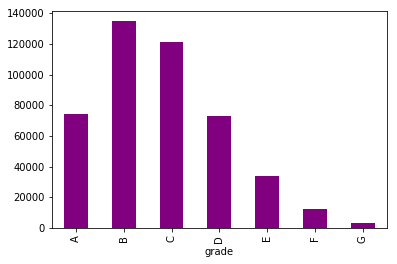

In [265]:
accepted.groupby(['grade']).size().plot(kind ='bar', color ='purple') 

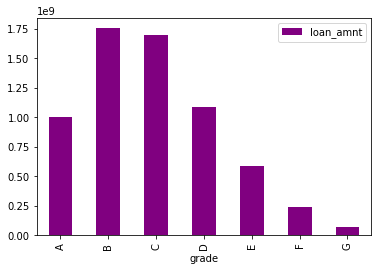

In [267]:
accepted.groupby(['grade']).agg({'loan_amnt':'sum'}).plot(kind ='bar', color ='purple')

## Loan default rate by grade

In [37]:
grade_lstatus = accepted.groupby(['grade', 'loan_status']).size().reset_index().rename(columns = {0:'count'})
grade_lstatus = grade_lstatus.merge(grade_lstatus.groupby('grade').agg({'count':'sum'}), on = 'grade')
grade_lstatus['prop'] = grade_lstatus['count_x']/grade_lstatus['count_y']
grade_lstatus.drop(columns = ['count_x', 'count_y'], inplace = True)

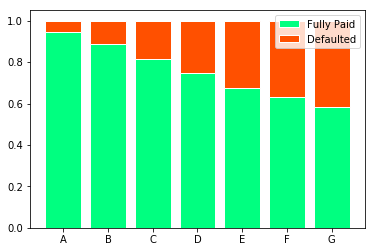

In [95]:
x = ['A','B','C','D','E','F','G']
grade_lstatus
defaulted = grade_lstatus.loc[grade_lstatus['loan_status'] == 'Defaulted', :]
fullypaid = grade_lstatus.loc[grade_lstatus['loan_status'] == 'FullyPaid', :]
# # plt.bar(x, term_by_grade['percentage'])
# # plt.xticks(rotation=90)

plt.bar(x, fullypaid['prop'], color='#00ff80', edgecolor='white', label="Fully Paid")

plt.bar(x, defaulted['prop'], bottom=fullypaid['prop'], color='#ff5000', edgecolor='white', label="Defaulted")
plt.legend()

In [64]:
defaulted.drop(columns = 'loan_status').set_index('grade').rename(columns={'prop':'Default Rate'})*100

,Default Rate
grade,
A,5.599882
B,11.294412
C,18.674157
D,25.222605
E,32.454768
F,36.702295
G,41.751269


### Default by purpose

In [102]:
purpose_lstatus = accepted.groupby(['purpose', 'loan_status']).size().reset_index().rename(columns = {0:'count'})
purpose_lstatus = purpose_lstatus.merge(purpose_lstatus.groupby('purpose').agg({'count':'sum'}), on = 'purpose')
purpose_lstatus['prop'] = purpose_lstatus['count_x']/purpose_lstatus['count_y']
purpose_lstatus.drop(columns = ['count_x', 'count_y'], inplace = True)

In [104]:
purpose_lstatus

,purpose,loan_status,prop
0,car,Defaulted,0.119361
1,car,FullyPaid,0.880639
2,credit_card,Defaulted,0.143209
3,credit_card,FullyPaid,0.856791
4,debt_consolidation,Defaulted,0.180983
5,debt_consolidation,FullyPaid,0.819017
6,educational,Defaulted,0.213759
7,educational,FullyPaid,0.786241
8,home_improvement,Defaulted,0.152479
9,home_improvement,FullyPaid,0.847521


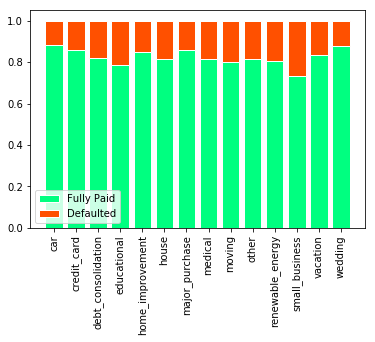

In [116]:
x = purpose_lstatus['purpose'].unique()

defaulted = purpose_lstatus.loc[purpose_lstatus['loan_status'] == 'Defaulted', :]
fullypaid = purpose_lstatus.loc[purpose_lstatus['loan_status'] == 'FullyPaid', :]
# # plt.bar(x, term_by_grade['percentage'])
plt.xticks(rotation=90)

plt.bar(x, fullypaid['prop'], color='#00ff80', edgecolor='white', label="Fully Paid")

plt.bar(x, defaulted['prop'], bottom=fullypaid['prop'], color='#ff5000', edgecolor='white', label="Defaulted")
plt.legend()

## Status of loan

In [120]:
accepted.columns


['grade', 'int_rate', 'fico_mid', 'purpose', 'term']

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       

In [146]:
to_cosider = ['annual_inc', 'dti', 'addr_state', 'delinq_2yrs', 'emp_length']

0.0     373162
1.0      54436
2.0      15724
3.0       5460
4.0       2257
5.0       1189
6.0        601
7.0        336
8.0        173
9.0        107
10.0        65
11.0        38
12.0        37
13.0        24
14.0         8
15.0         7
18.0         6
16.0         5
19.0         3
17.0         3
21.0         2
22.0         2
29.0         1
24.0         1
Name: delinq_2yrs, dtype: int64

In [41]:
paid_f = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
 
current = ['Current', 'Late (16-30 days)', 'In Grace Period']

defaulted = ['Default','Does not meet the credit policy. Status:Charged Off', 'Charged Off', 'Late (31-120 days)']

accepted.drop(
    index = accepted.loc[[True if row in current else False for row in accepted['loan_status']], 'loan_status'].index,
    inplace = True)

accepted['loan_status'] = accepted['loan_status'].apply(lambda s: 'FullyPaid' if s in paid_f else 'Defaulted')

In [143]:
# accepted.loc[:, 'emp_title':]
# ['term', 'grade', 'sub_grade', 
#  'emp_title', 'emp_length', 'home_ownership', 
#  'verification_status', 'pymnt_plan', ]



In [42]:
accepted['loan_status'].value_counts()

status = accepted.groupby("loan_status")[["loan_status"]].count()
status = accepted.groupby("loan_status")[["loan_status"]].count()
status['ratio'] = ((status[['loan_status']]/accepted.shape[0])*100).round(2)

status.sort_values(by=["ratio"], ascending=False)

,loan_status,ratio
loan_status,,
PaidFull,376150,82.92
Defaulted,77497,17.08


### Interest rate by grade/subgrade

In [80]:
#Median interest rate by grade
accepted.groupby(['grade']).agg({"int_rate":"median"})

,int_rate
grade,
A,7.68
B,11.67
C,14.49
D,17.57
E,20.50
F,23.76
G,25.80


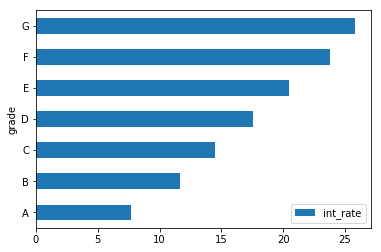

In [47]:
#bar charts for median interest rate by grade
int_r = accepted.groupby(['grade']).agg({"int_rate":"median"})
int_r.plot.barh()

### Percentage of term by grade 

In [81]:
term_by_grade          = accepted.groupby(['grade', 'term']).agg({'id':'count'})
term_by_grade.columns  = pd.Index(['count'])
count_by_grade         = term_by_grade.groupby('grade').agg({'count':'sum'})
count_by_grade.columns = pd.Index(['total_by_grade'])

In [82]:
temp                = term_by_grade.index
term_by_grade       = term_by_grade.merge(count_by_grade, how = 'left', on = 'grade')
term_by_grade.index = temp

In [83]:
term_by_grade['percentage'] = term_by_grade['count']/term_by_grade['total_by_grade']
term_by_grade.drop(columns  = ['count', 'total_by_grade'], inplace = True)
term_by_grade.reset_index(inplace = True)

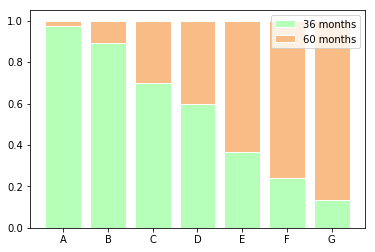

In [85]:
x = ['A','B','C','D','E','F','G']

short_term = term_by_grade.loc[term_by_grade['term'] == ' 36 months', :]
long_term = term_by_grade.loc[term_by_grade['term'] == ' 60 months', :]
# plt.bar(x, term_by_grade['percentage'])
# plt.xticks(rotation=90)

plt.bar(x, short_term['percentage'], color='#b5ffb9', edgecolor='white', label="36 months")

plt.bar(x, long_term['percentage'], bottom=short_term['percentage'], color='#f9bc86', edgecolor='white', label="60 months")
plt.legend()

### Return by grade

In [226]:
accepted['invest_return_per'] = (accepted['total_pymnt'] - accepted['funded_amnt'])/accepted['funded_amnt']
accepted['invest_return'] = accepted['total_pymnt'] - accepted['funded_amnt']

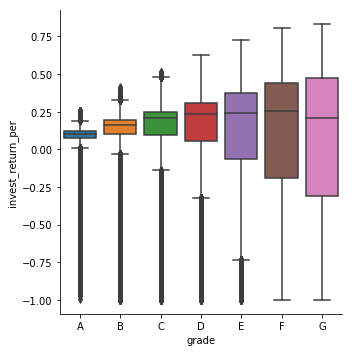

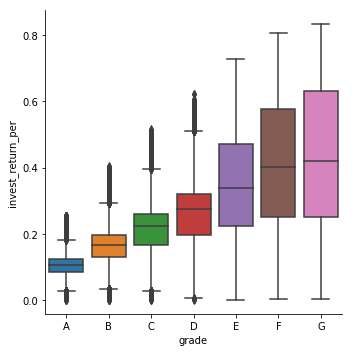

In [239]:
sns.catplot(x='grade', y='invest_return_per', kind="box", data=accepted, order = x)


sns.catplot(x='grade', y='invest_return_per', kind="box", data=accepted.loc[accepted['loan_status'] == 'PaidFull', :], order = x)

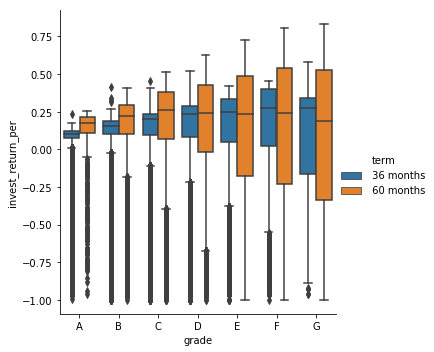

In [241]:
sns.catplot(x='grade', y='invest_return_per', kind='box', hue='term', data=accepted, order=x)

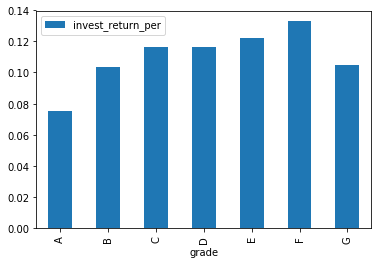

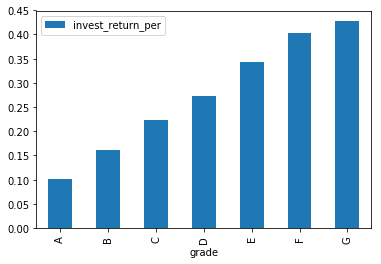

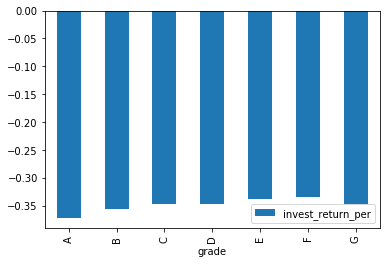

In [74]:
inv_return_total = accepted.groupby(['grade']).agg({'invest_return':'mean', 'invest_return_per':'mean'}).reset_index()

inv_return_fully_paid = accepted.loc[accepted['loan_status'] == 'FullyPaid', :].groupby(['grade']).agg({'invest_return':'mean', 'invest_return_per':'mean'}).reset_index()

inv_return_fully_default = accepted.loc[accepted['loan_status'] == 'Defaulted', :].groupby(['grade']).agg({'invest_return':'mean', 'invest_return_per':'mean'}).reset_index()


# inv_return_total = inv_return_total.reset_index().drop(columns  = 'grade')
inv_return_total.plot.bar(x = 'grade', y = 'invest_return_per')

# inv_return_fully_paid = inv_return_fully_paid.reset_index().drop(columns  = 'grade')
inv_return_fully_paid.plot.bar(x = 'grade', y = 'invest_return_per')

# inv_return_fully_default = inv_return_fully_default.reset_index().drop(columns  = 'grade')
inv_return_fully_default.plot.bar(x = 'grade', y = 'invest_return_per')

### Survival of loan

In [255]:
survival_days = accepted.groupby(['grade', 'term']).agg({'duration_days':'mean'}).reset_index()

In [256]:
survival_days['term'] = survival_days['term'].apply(lambda s: 1095 if s == ' 36 months' else 5*365)

In [257]:
survival_days

,grade,term,duration_days
0,A,1095,794.082350
1,A,1825,1111.497714
2,B,1095,770.431343
3,B,1825,1027.761885
4,C,1095,736.224938
5,C,1825,972.826170
6,D,1095,715.429776
7,D,1825,891.120647
8,E,1095,692.056145
9,E,1825,853.585663


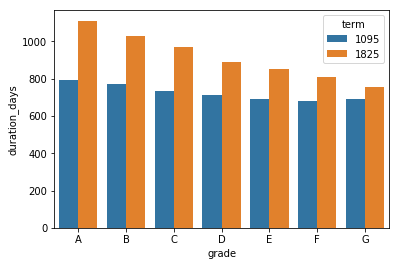

In [258]:
sns.barplot(x = 'grade', y = 'duration_days', hue = 'term', data = survival_days)

In [260]:
survival_months = accepted.groupby(['grade', 'term']).agg({'duration_months':'mean'}).reset_index()

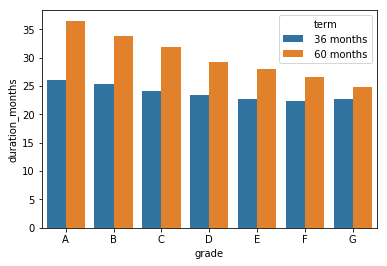

In [262]:
sns.barplot(x = 'grade', y = 'duration_months', hue = 'term', data = survival_months)

### Purpose